In [1]:
# Setting up the environment for plotting

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.ticker as mtick


scenario_map = {
    "ETS_conformal": "Scenario 1",
    "LOCNESS_conformal": "Scenario 2",
    "ETS_conformal_weighted": "Scenario 3",
}

output_dir = "figs"
os.makedirs(output_dir, exist_ok=True)

def plot_heatmap(ax, grouped, title, xlabel = "Alternative", ylabel = "Null", plot_sd=True, annot_kws_size=10, fontsize=15):
    mean = grouped.mean().unstack()
    std = grouped.std().unstack()
    
    # if there is nan in std, remove make the corresponding mean nan
    std = std.where(~std.isna(), np.nan)
    mean = mean.where(~std.isna(), np.nan)

    annot = pd.DataFrame('', index=mean.index, columns=mean.columns)

    for row in mean.index:
        for col in mean.columns:
            mean_val = mean.loc[row, col]
            std_val = std.loc[row, col]
            if not np.isnan(mean_val):
                if plot_sd:
                    annot.loc[row, col] = f"{mean_val:.2f}\n({std_val:.2f})"
                else:
                    annot.loc[row, col] = f"{mean_val:.2f}"
    

    sns.heatmap(mean, annot=annot, annot_kws={"size": annot_kws_size}, fmt="", cmap="YlGnBu",
                cbar=False,
                linewidths=0, linecolor='gray',
                ax=ax)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize - 2)
    ax.tick_params(axis='y', labelsize=fontsize - 2)
    if ylabel != "Null":
        ax.tick_params(axis='y', left=False)
    else:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


def load_result(dataset, model, method, cols):
    result_prefix = "results"
    result_file = f"{result_prefix}/{dataset}_{model}_{method}.csv"
    print(f"Loading results from {result_file}")
    df = pd.read_csv(result_file)

    if 'alternatives' in cols:
        df['alternatives'] = df['alternatives'].apply(lambda x: eval(x)[0])
        
    group_sizes = df.groupby(['base', 'alternatives']).size()
    valid_groups = group_sizes[group_sizes >= group_sizes.max()].index
    df_filtered = df.set_index(['base', 'alternatives']).loc[valid_groups].reset_index()

    df_filtered = df_filtered[cols]

    return df_filtered


# Proportion of Adjusted Outliers

We created a spectrum of AI interventions with seven distinct levels of increasing modification, using the following prompting templates:

- ``Correct only spelling and grammatical errors in the following essay. Do not change wording, phrasing, punctuation (unless part of a grammar fix) or style.''
    
- ``Correct grammar, spelling, and any awkward sentence constructions in the following essay. Keep the original voice and tone. Do not rewrite for clarity unless absolutely necessary.''
    
- ``Improve clarity in the following essay by reordering or rephrasing within paragraphs only. Do not cut or add content. Keep the original sentences where possible.''
    
- ``Assess the logical flow of this essay and revise it to improve coherence or address reasoning gaps. Keep the original wording and structure as intact as possible.''
    
- ``Revise the following essay to enhance readability and clarity, while keeping the original wording as intact as possible.''
    
- ``Please revise the following essay to improve sentence transitions and flow. Do not add new content or examples—only improve how existing ideas are connected and expressed.''
    
- ``Expand on the essay below to complete it.'' (For writing-prompt-specific essays (ETS corpus), we used: ``Help me write an essay responding to the following prompt: \[prompt\]. Here is the text I have written so far as a starting point: \[essay\]. Please build upon my ideas, keeping the original tone, style, and viewpoint.''

Before we analyze the results, we need to adjust the outliers for each level of intervention. An adjusted outlier exemplifies a situation where a student violates AI-usage guidelines and the result leads to significant changes in the essay, as measured by a low BLEU score, i.e. below $\alpha = 0.05$ quantile of the held-out dataset.

Observing the proportion of adjusted outliers as a percentage of the total number of essays intervened using the alternative AI interventions, we can see how the proportion of adjusted outliers changes with the level of permitted AI intervention. 

model: phi, method: openai
Loading results from results/ETS_conformal_phi_openai.csv
Loading results from results/LOCNESS_conformal_phi_openai.csv


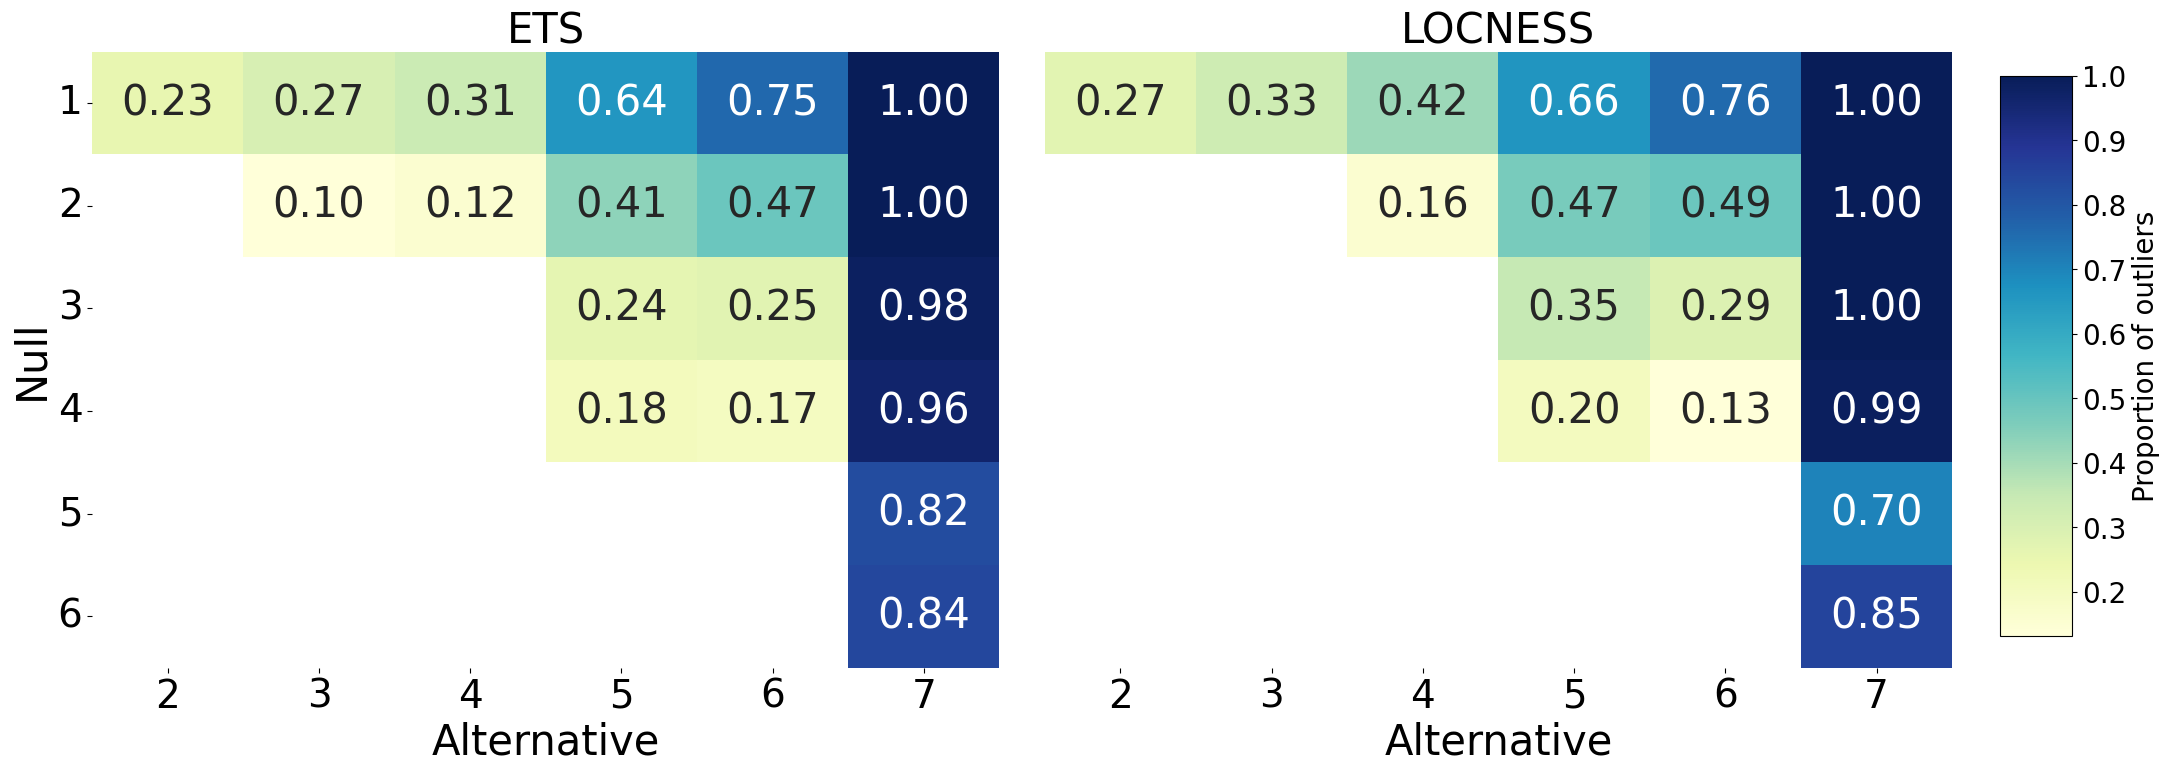

model: qwen, method: openai
Loading results from results/ETS_conformal_qwen_openai.csv
Loading results from results/LOCNESS_conformal_qwen_openai.csv


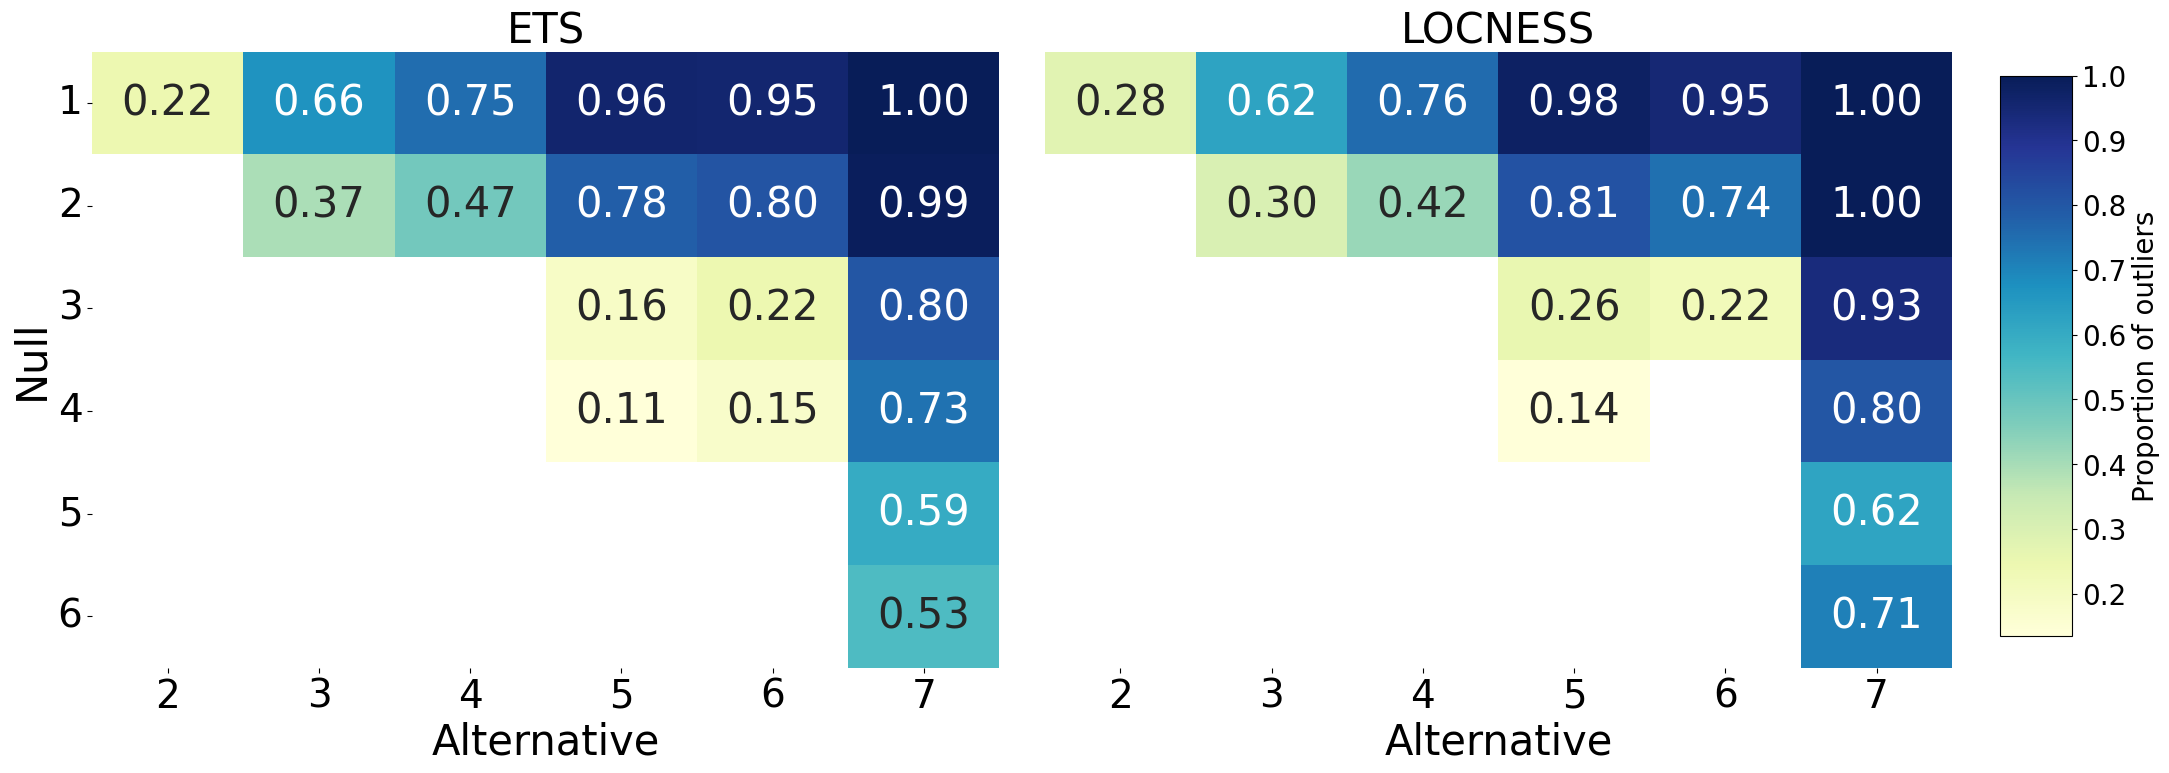

model: phi, method: maryland
Loading results from results/ETS_conformal_phi_maryland.csv
Loading results from results/LOCNESS_conformal_phi_maryland.csv


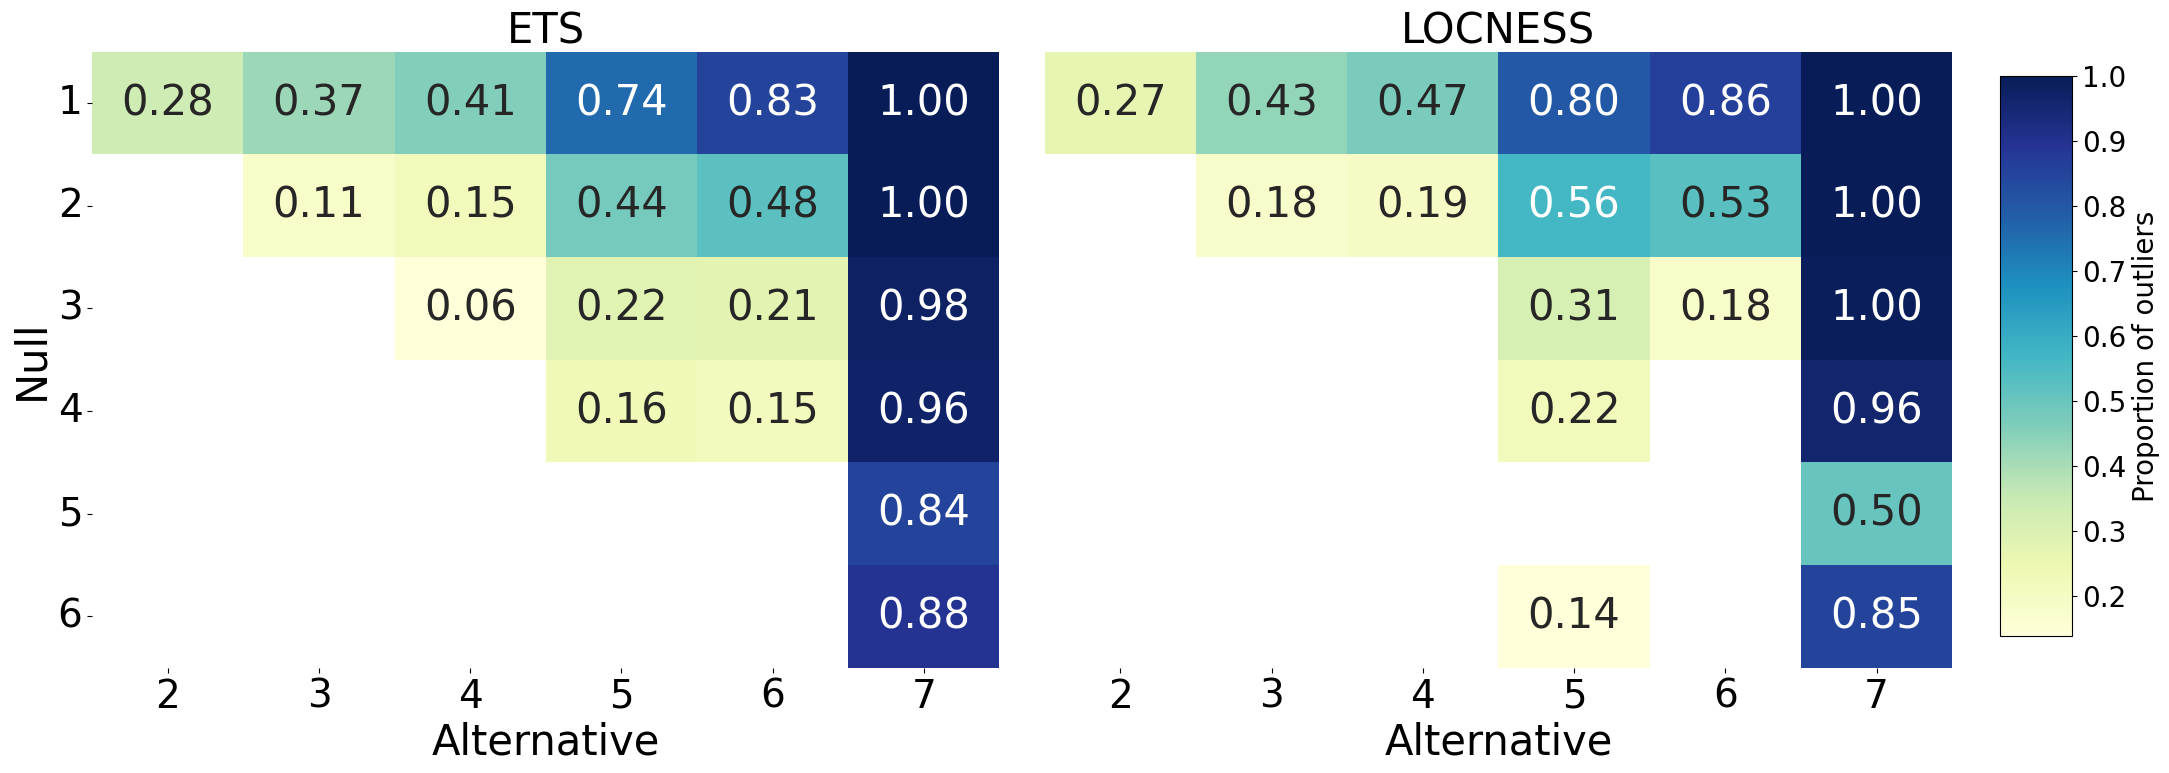

model: qwen, method: maryland
Loading results from results/ETS_conformal_qwen_maryland.csv
Loading results from results/LOCNESS_conformal_qwen_maryland.csv


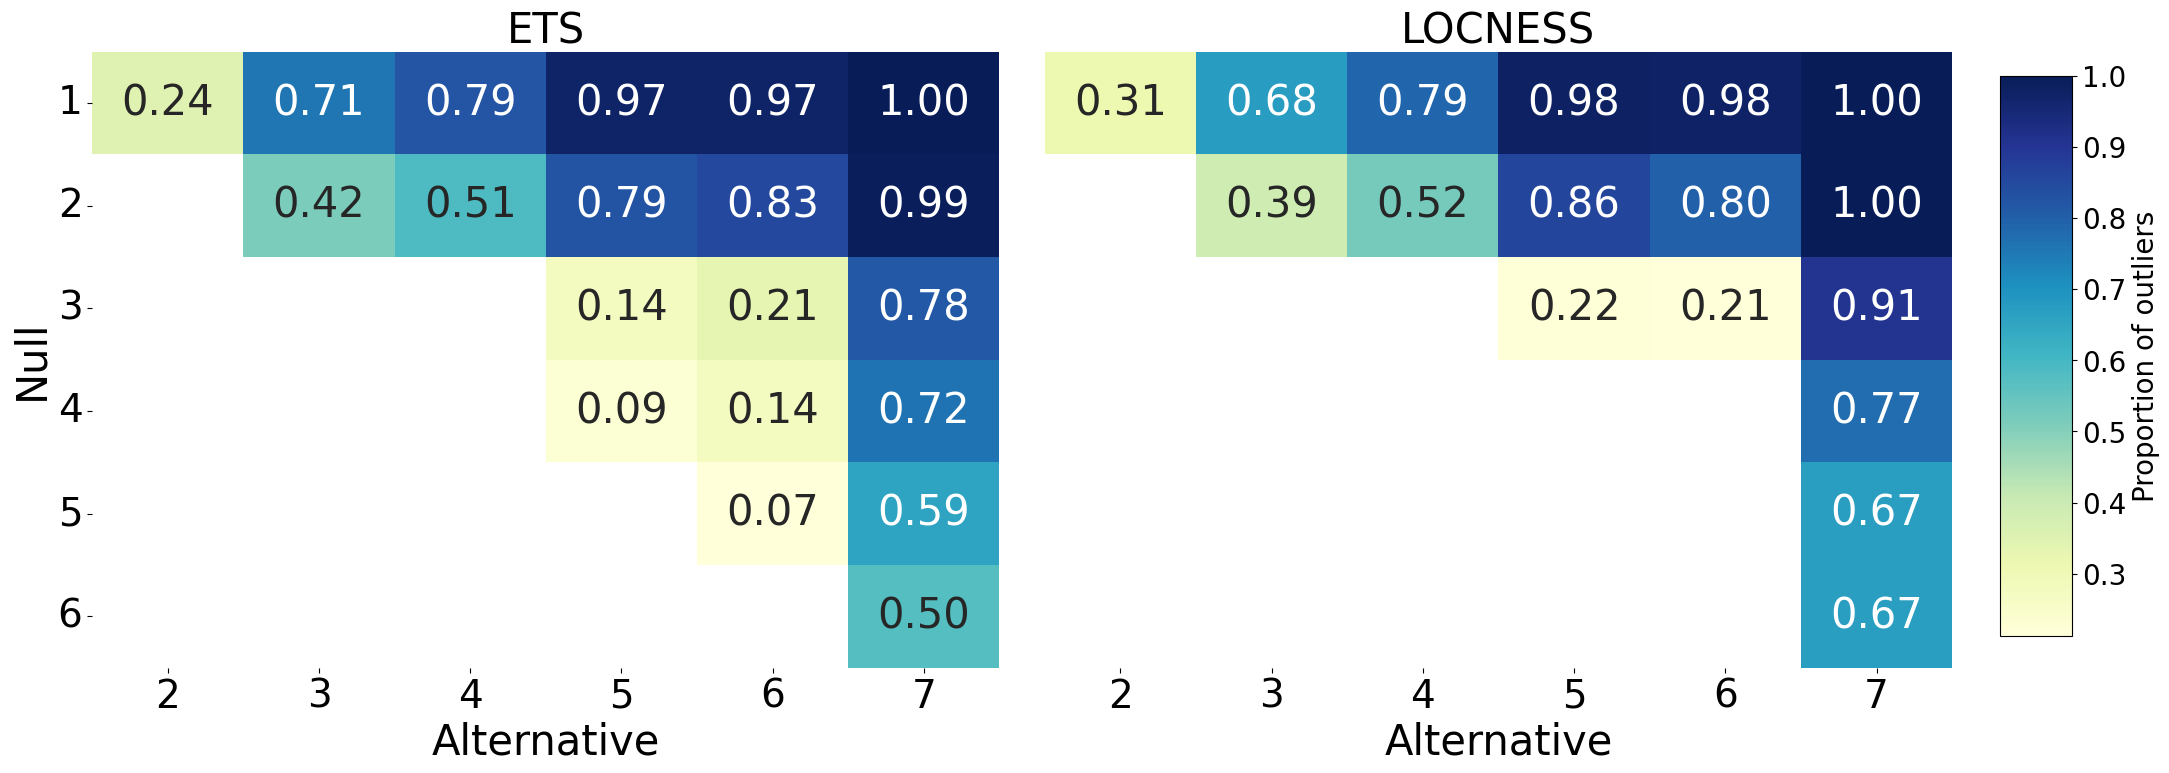

In [2]:
for method in ["openai", "maryland"]:
    for model in ["phi", "qwen"]:
        print(f"model: {model}, method: {method}")
        
        # Create a new figure for each (model, method)
        fig_heatmap, axes_heatmap = plt.subplots(1, 2, figsize=(1 * 24, 2 * 4), sharey=True, gridspec_kw={'wspace': 0.05})
        axes_heatmap = axes_heatmap.flatten()
        mappable_for_cbar = None

        for idx, dataset in enumerate(["ETS_conformal", "LOCNESS_conformal"]):
            ax = axes_heatmap[idx]

            df = load_result(dataset, model, method, ['base', 'alternatives', 'Outliers', 'total_samples'])
            df['Outlier_proportion'] = df['Outliers'] / df['total_samples']
            
            df_outliers = df.groupby(['base', 'alternatives'])['Outlier_proportion']

            plot_heatmap(ax, df_outliers, "ETS" if dataset == "ETS_conformal" else "LOCNESS", plot_sd=False, annot_kws_size=30, fontsize=30,
                            xlabel="Alternative", ylabel="Null" if idx == 0 else "")

            if ax.collections:
                mappable_for_cbar = ax.collections[0]

        if mappable_for_cbar is not None:
            cbar_ax = fig_heatmap.add_axes([0.92, 0.15, 0.03, 0.7])
            cbar = fig_heatmap.colorbar(mappable_for_cbar, cax=cbar_ax)
            cbar.ax.tick_params(labelsize=20)
            cbar.set_label('Proportion of outliers', fontsize=20)

        plt.savefig(f"figs/{model}_{method}_outliers_rate_base_alternative.png", dpi=300)
        plt.show()
        plt.close(fig_heatmap)

model: phi, method: openai
Loading results from results/ETS_conformal_phi_openai.csv
Average distance from 5% FPR for phi-openai on ETS_conformal:
n_train
30     3.199495
50     2.301184
200    1.324118
Loading results from results/LOCNESS_conformal_phi_openai.csv
Average distance from 5% FPR for phi-openai on LOCNESS_conformal:
n_train
30     3.264264
50     3.048048
200    1.588589


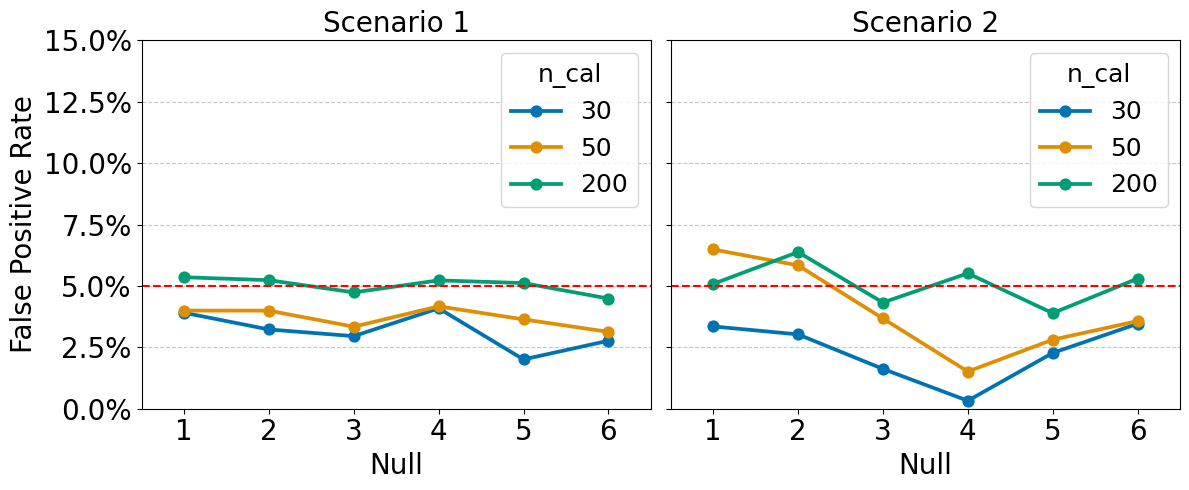

model: qwen, method: openai
Loading results from results/ETS_conformal_qwen_openai.csv
Average distance from 5% FPR for qwen-openai on ETS_conformal:
n_train
30     3.084435
50     2.360208
200    1.282611
Loading results from results/LOCNESS_conformal_qwen_openai.csv
Average distance from 5% FPR for qwen-openai on LOCNESS_conformal:
n_train
30     3.318318
50     2.906907
200    1.372372


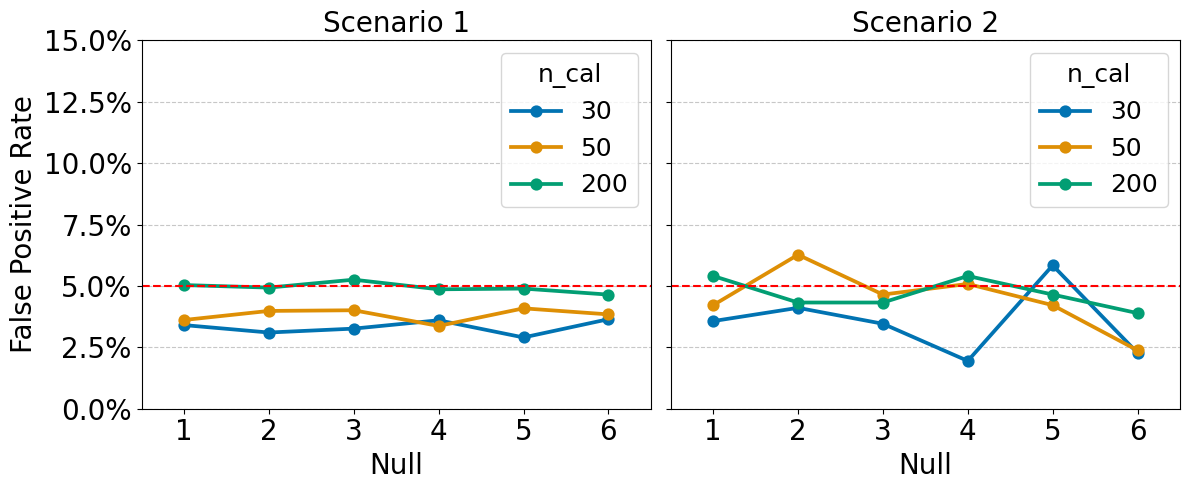

model: phi, method: maryland
Loading results from results/ETS_conformal_phi_maryland.csv
Average distance from 5% FPR for phi-maryland on ETS_conformal:
n_train
30     3.054234
50     2.415181
200    1.355676
Loading results from results/LOCNESS_conformal_phi_maryland.csv
Average distance from 5% FPR for phi-maryland on LOCNESS_conformal:
n_train
30     3.631579
50     2.761024
200    2.021337


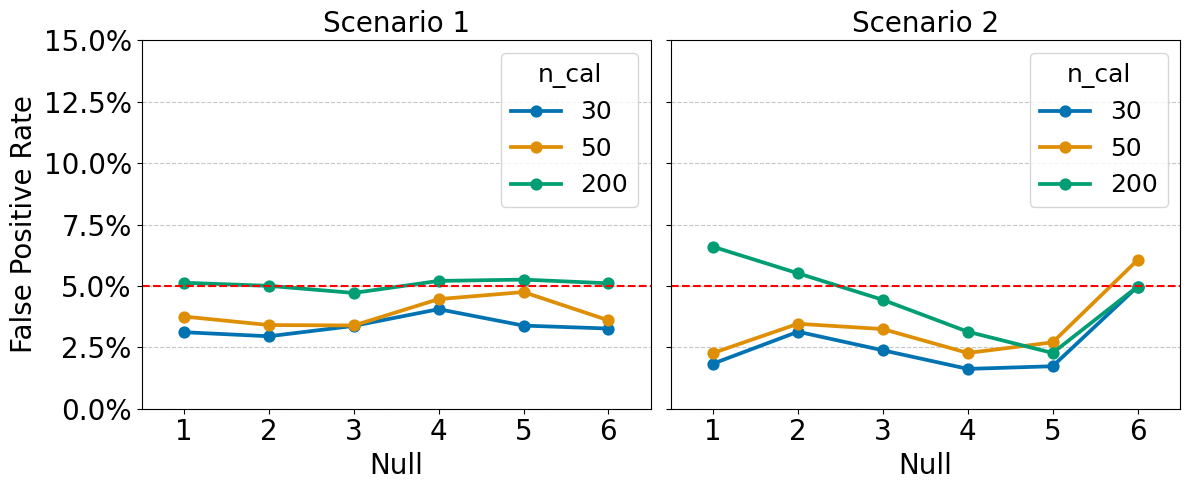

model: qwen, method: maryland
Loading results from results/ETS_conformal_qwen_maryland.csv
Average distance from 5% FPR for qwen-maryland on ETS_conformal:
n_train
30     3.242985
50     2.464859
200    1.378566
Loading results from results/LOCNESS_conformal_qwen_maryland.csv
Average distance from 5% FPR for qwen-maryland on LOCNESS_conformal:
n_train
30     3.585056
50     2.570747
200    2.087440


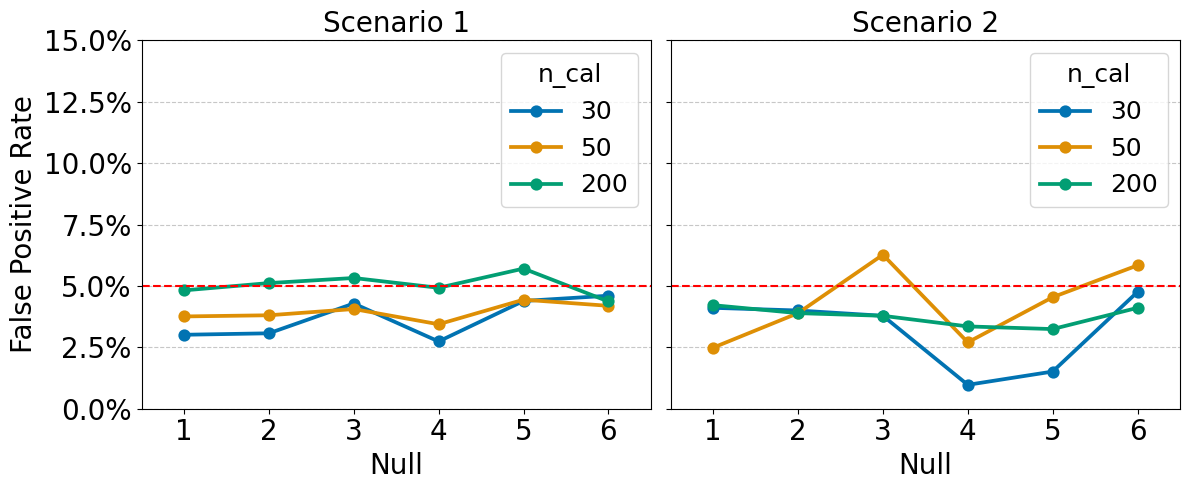

In [3]:
for method in ["openai", "maryland"]:
    for model in ["phi", "qwen"]:
        print(f"model: {model}, method: {method}")
        
        # Create a single figure with 2 subplots for the two scenarios
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

        for idx, dataset in enumerate(["ETS_conformal", "LOCNESS_conformal"]):
            df_fpr = load_result(dataset, model, method, ['base', 'n_train', 'False positive rate'])
            # Compute average absolute distance from 5% FPR
            df_fpr['abs_dist'] = (df_fpr['False positive rate'] - 5).abs()
            avg_dist = df_fpr.groupby('n_train')['abs_dist'].mean()

            # Print or log the result
            print(f"Average distance from 5% FPR for {model}-{method} on {dataset}:")
            print(avg_dist.to_string())

            ax = axes[idx]
            sns.pointplot(
                x='base', y='False positive rate', hue='n_train', data=df_fpr,
                palette='colorblind', errorbar=None, marker='o', ax=ax
            )
            ax.axhline(y=5, color='red', linestyle='--')
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
            ax.set_ylim(0, 15)

            ax.set_xlabel('Null', fontsize=20)
            if idx == 0:
                ax.set_ylabel('False Positive Rate', fontsize=20)
            else:
                ax.set_ylabel('')

            ax.set_title(scenario_map.get(dataset, "Unknown Scenario"), fontsize=20)

            ax.legend(title='n_cal', loc='best', title_fontsize=18, fontsize=18)
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=20)
            ax.tick_params(axis='y', labelsize=20)

        plt.tight_layout()
        combined_figure_name = f"figs/{model}_{method}_fpr_combined.png"
        plt.savefig(combined_figure_name, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)

model: phi, method: openai
Processing dataset: ETS_conformal
Loading results from results/ETS_conformal_phi_openai.csv
Plotting n_cal = 30
Plotting n_cal = 50
Plotting n_cal = 200


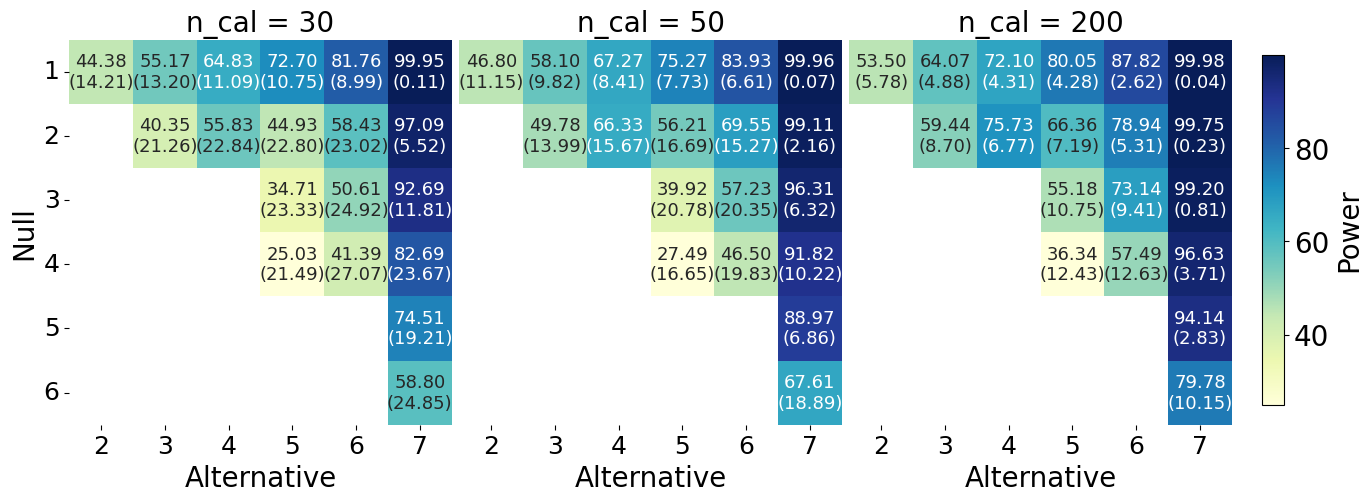

Processing dataset: LOCNESS_conformal
Loading results from results/LOCNESS_conformal_phi_openai.csv
Plotting n_cal = 30
Plotting n_cal = 50
Plotting n_cal = 200


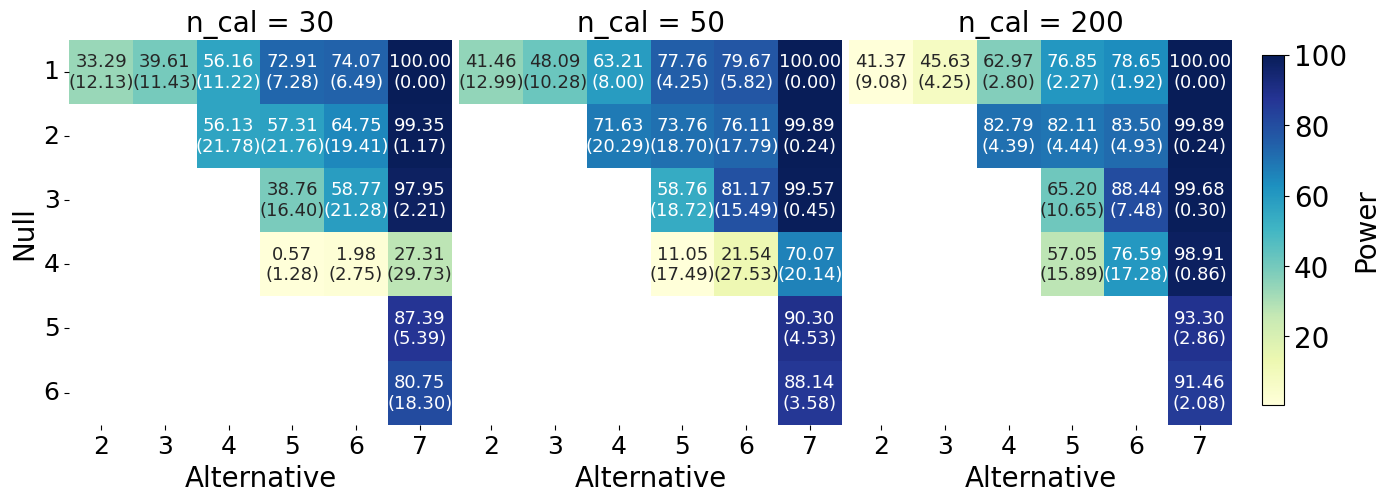

model: qwen, method: openai
Processing dataset: ETS_conformal
Loading results from results/ETS_conformal_qwen_openai.csv
Plotting n_cal = 30
Plotting n_cal = 50
Plotting n_cal = 200


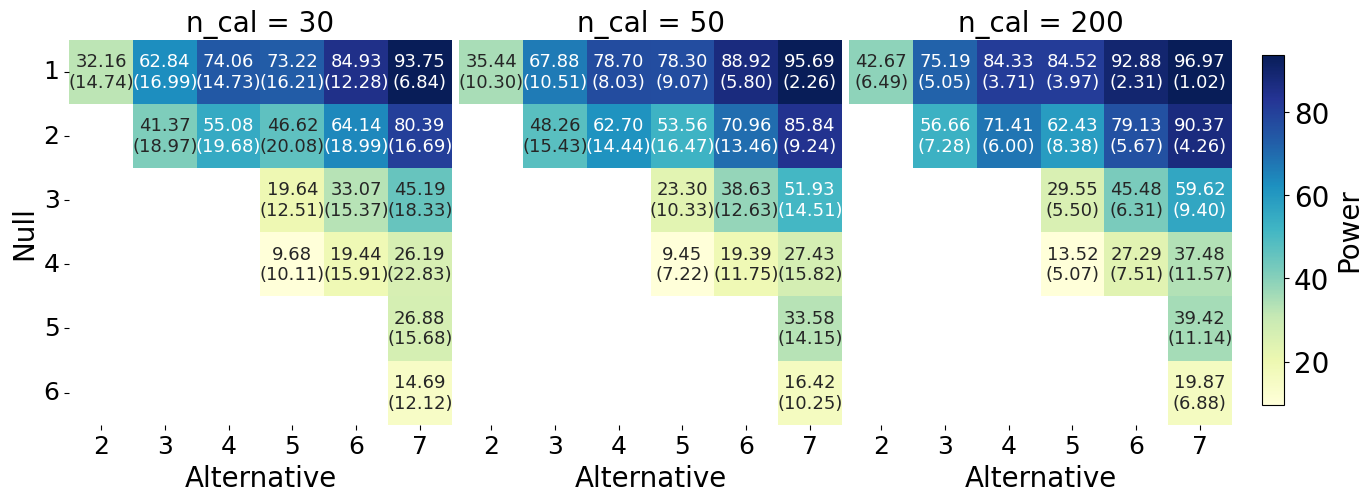

Processing dataset: LOCNESS_conformal
Loading results from results/LOCNESS_conformal_qwen_openai.csv
Plotting n_cal = 30
Plotting n_cal = 50
Plotting n_cal = 200


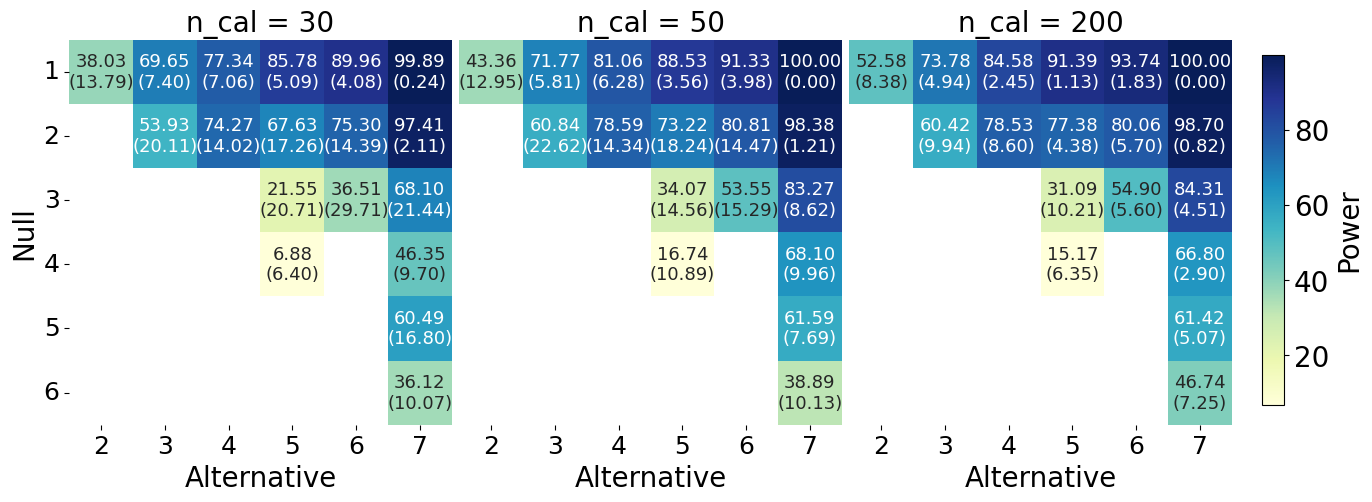

model: phi, method: maryland
Processing dataset: ETS_conformal
Loading results from results/ETS_conformal_phi_maryland.csv
Plotting n_cal = 30
Plotting n_cal = 50
Plotting n_cal = 200


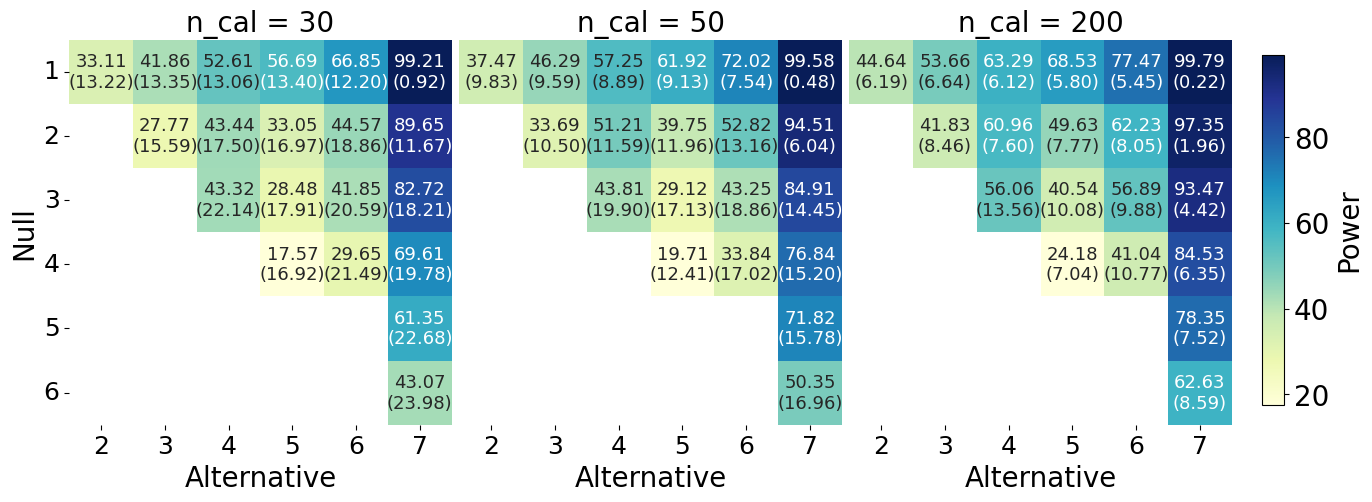

Processing dataset: LOCNESS_conformal
Loading results from results/LOCNESS_conformal_phi_maryland.csv
Plotting n_cal = 30
Plotting n_cal = 50
Plotting n_cal = 200


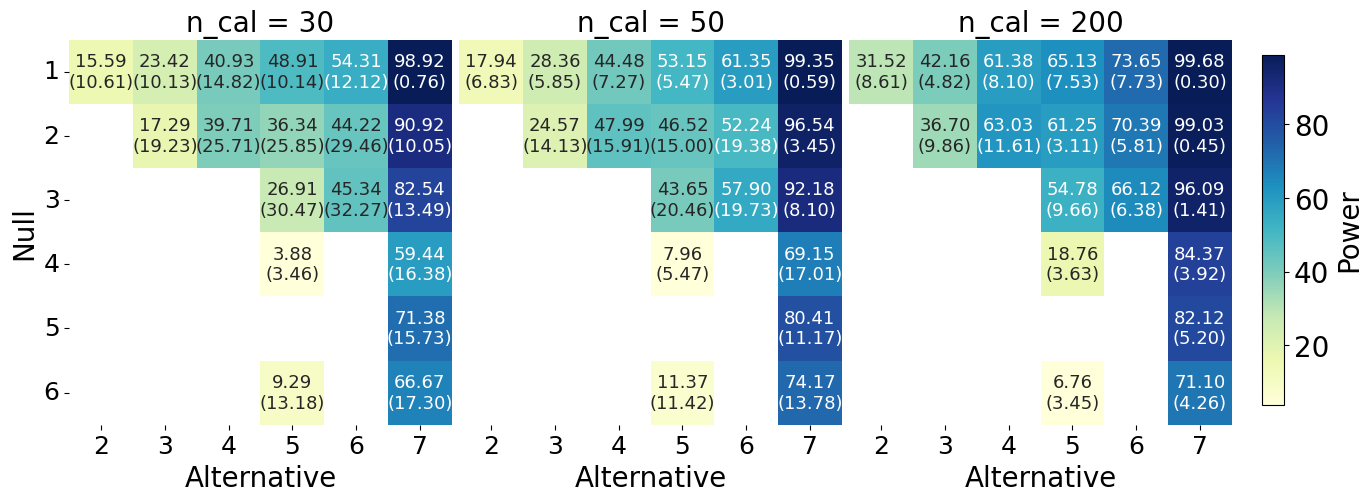

model: qwen, method: maryland
Processing dataset: ETS_conformal
Loading results from results/ETS_conformal_qwen_maryland.csv
Plotting n_cal = 30
Plotting n_cal = 50
Plotting n_cal = 200


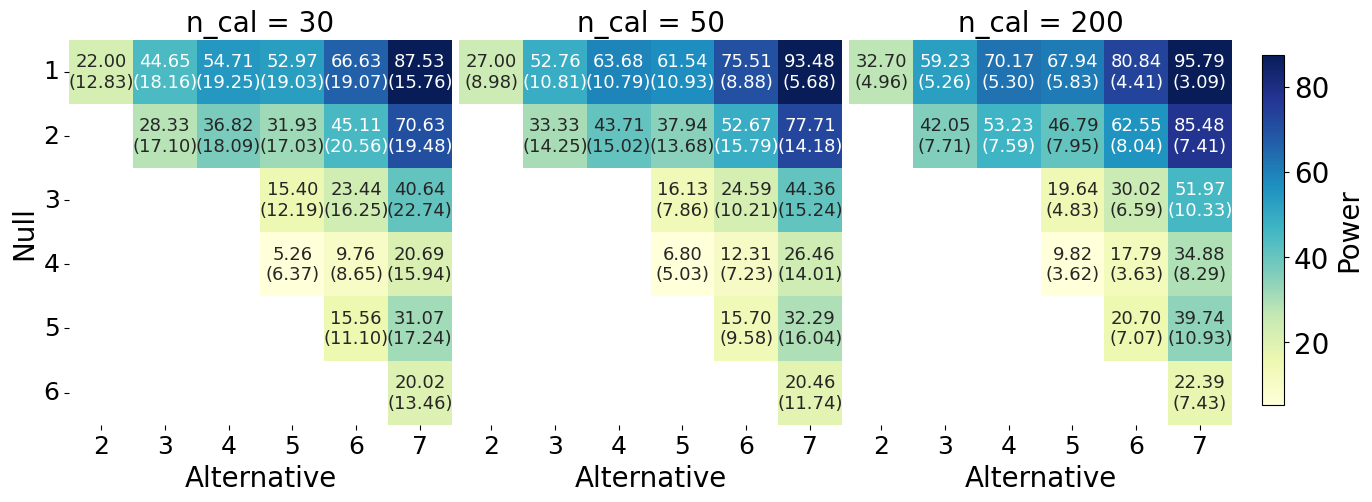

Processing dataset: LOCNESS_conformal
Loading results from results/LOCNESS_conformal_qwen_maryland.csv
Plotting n_cal = 30
Plotting n_cal = 50
Plotting n_cal = 200


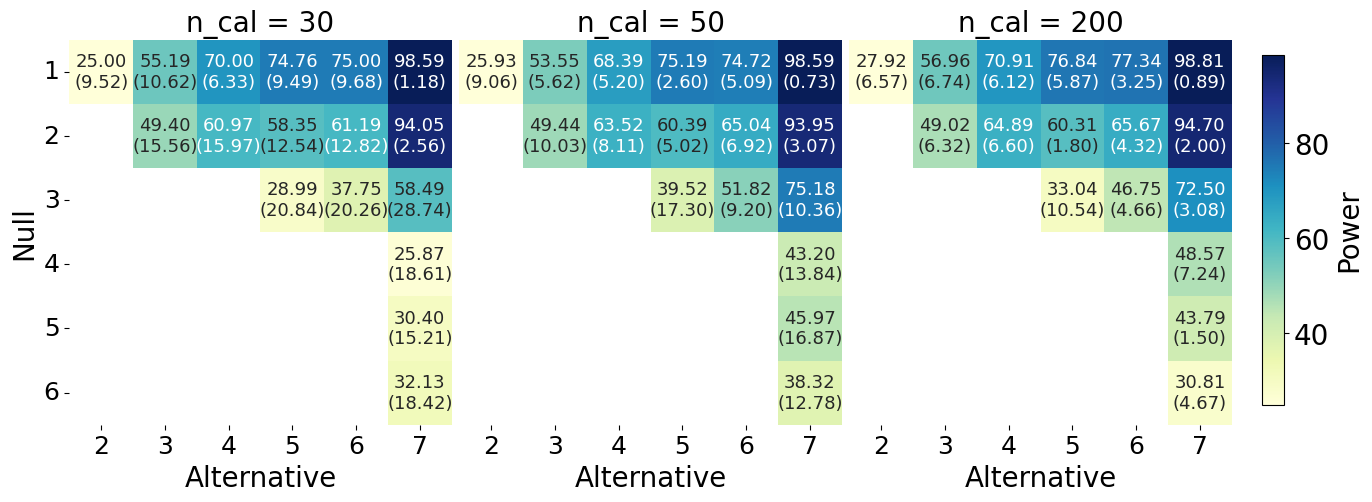

In [8]:
for method in ["openai", "maryland"]:
    for model in ["phi", "qwen"]:
        print(f"model: {model}, method: {method}")
        
        for dataset in ["ETS_conformal", "LOCNESS_conformal"]:
            print(f"Processing dataset: {dataset}")
            
            df = load_result(dataset, model, method, ['base', 'alternatives', 'n_train', 'Power'])
            unique_n_trains = sorted(df['n_train'].unique())
            num_n_trains = len(unique_n_trains)
            
            # Create a row of subplots for each n_train
            fig_heatmap, axes_heatmap = plt.subplots(1, num_n_trains, figsize=(5 * num_n_trains, 5), sharey=True, 
                         gridspec_kw={'wspace': 0.02})
            if num_n_trains == 1:
                axes_heatmap = [axes_heatmap]  # force iterable if only one axis
            else:
                axes_heatmap = axes_heatmap.flatten()

            mappable_for_cbar = None

            for idx, n_train in enumerate(unique_n_trains):
                show_ylabel = (idx == 0)
                ax = axes_heatmap[idx]
                print(f"Plotting n_cal = {n_train}")
                df_power = df[df['n_train'] == n_train].groupby(['base', 'alternatives'])['Power']

                # print the df_power for debugging as the same table in the heatmap
                #print(df_power.mean().unstack())
                plot_heatmap(ax, df_power, title=f"n_cal = {n_train}", fontsize=20, ylabel="Null" if show_ylabel else "", annot_kws_size=13)

                if mappable_for_cbar is None and ax.collections:
                    mappable_for_cbar = ax.collections[0]

            if mappable_for_cbar is not None:
                cbar_ax = fig_heatmap.add_axes([0.92, 0.15, 0.015, 0.7])
                cbar = fig_heatmap.colorbar(mappable_for_cbar, cax=cbar_ax)
                cbar.ax.tick_params(labelsize=20)
                cbar.set_label('Power', fontsize=20)

            out_path = f"figs/{dataset}_{model}_{method}_power_base_alternative.png"
            plt.savefig(out_path, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close(fig_heatmap)

In [5]:
import pandas as pd

def format_latex_table_scenario_3(model, method, n_train, dataset):
    print(f"Loading data for model={model}, method={method}, n_train={n_train}, dataset={dataset}")
    df = load_result(dataset, model, method, ['base', 'alternatives', 'n_train', 'Power', 'category', 'False positive rate'])

    # Sanity check: Print shape and head
    if df.empty:
        return "Warning: No data loaded."

    df = df[df['n_train'] == n_train]
    if df.empty:
        return f"Warning: No rows with n_train = {n_train}"

    # Normalize columns
    df['base'] = df['base'].apply(lambda x: eval(str(x)))
    df['alternatives'] = df['alternatives'].apply(lambda x: eval(str(x)))
    df['base'] = df['base'].apply(lambda x: x[0] if isinstance(x, list) else x)
    df['alternatives'] = df['alternatives'].apply(lambda x: x[0] if isinstance(x, list) else x)

    # Average
    df_avg = df.groupby(['base', 'alternatives', 'category'])[['False positive rate', 'Power']].mean().round(1).reset_index()
    if df_avg.empty:
        return "Warning: Groupby-mean produced empty result."

    # Pivot
    try:
        pivot_fpr = df_avg.pivot(index=['base', 'alternatives'], columns='category', values='False positive rate')
        pivot_power = df_avg.pivot(index=['base', 'alternatives'], columns='category', values='Power')
    except Exception as e:
        return f"Error during pivot: {e}"

    # Combine FPR and Power
    pivot = pd.concat({'FPR': pivot_fpr, 'Power': pivot_power}, axis=1)
    pivot = pivot.sort_index()
    if pivot.empty:
        return "Warning: Final pivot is empty."

    # LaTeX header
    header = f"""\\begin{{table}}[h!]
\\centering
\\caption{{Conformal Test Results for Model: {model}, Method: {method}, $m = {n_train}$}}
\\label{{tab:conformal_results_{model}_{method}_n{n_train}}}
\\resizebox{{\\textwidth}}{{!}}{{%
\\begin{{tabular}}{{c c | c c | c c | c c | c c }}
\\toprule
Null & Alt. & \\multicolumn{{2}}{{c|}}{{In Dist. Only}} & \\multicolumn{{2}}{{c|}}{{Comb. Unweighted}} & \\multicolumn{{4}}{{c}}{{Comb. Weighted}}\\\\
& & & & & & \\multicolumn{{2}}{{c|}}{{Quantile}} & \\multicolumn{{2}}{{c}}{{Mean}} \\\\
& & FPR & Power & FPR & Power & FPR & Power & FPR & Power \\\\
\\midrule
"""

    rows = []
    current_base = None
    for (base, alt), data in pivot.iterrows():
        new_base = base != current_base
        if current_base is not None and new_base:
            rows.append("\\midrule")

        row = f"{base} & {alt}" if new_base else f"~ & {alt}"
        current_base = base

        for cat in ["In Distribution Only", "Combined Unweighted", "Combined Weighted (quantile)", "Combined Weighted (mean)"]:
            fpr = data['FPR'].get(cat, '~')
            power = data['Power'].get(cat, '~')
            fpr = f"{fpr:.1f}" if new_base and pd.notna(fpr) else "~"
            power = f"{power:.1f}" if pd.notna(power) else "~"
            row += f" & {fpr} & {power}"
        rows.append(row + " \\\\")

    footer = "\n\\bottomrule\n\\end{tabular}\n}\\end{table}"

    return header + "\n".join(rows) + footer

In [6]:
for method in ["openai", "maryland"]:
    for model in ["phi", "qwen"]:
        for n_train in [5, 15, 30]:
            latex_table = format_latex_table_scenario_3(model, method, n_train, 'ETS_conformal_weighted')
            # save the LaTeX table to a file
            with open(f"tables/{model}_{method}_n{n_train}_ETS_conformal_weighted.tex", 'w') as f:
                f.write(latex_table)

Loading data for model=phi, method=openai, n_train=5, dataset=ETS_conformal_weighted
Loading results from results/ETS_conformal_weighted_phi_openai.csv
Loading data for model=phi, method=openai, n_train=15, dataset=ETS_conformal_weighted
Loading results from results/ETS_conformal_weighted_phi_openai.csv
Loading data for model=phi, method=openai, n_train=30, dataset=ETS_conformal_weighted
Loading results from results/ETS_conformal_weighted_phi_openai.csv
Loading data for model=qwen, method=openai, n_train=5, dataset=ETS_conformal_weighted
Loading results from results/ETS_conformal_weighted_qwen_openai.csv
Loading data for model=qwen, method=openai, n_train=15, dataset=ETS_conformal_weighted
Loading results from results/ETS_conformal_weighted_qwen_openai.csv
Loading data for model=qwen, method=openai, n_train=30, dataset=ETS_conformal_weighted
Loading results from results/ETS_conformal_weighted_qwen_openai.csv
Loading data for model=phi, method=maryland, n_train=5, dataset=ETS_conformal_

In [7]:
import pandas as pd

def format_latex_table_scenario_3_main_text(model, method, dataset):
    print(f"Loading data for model={model}, method={method}, dataset={dataset}")
    df = load_result(dataset, model, method, ['base', 'alternatives', 'n_train', 'Power', 'category', 'False positive rate'])

    # Sanity check: Print shape and head
    if df.empty:
        return "Warning: No data loaded."

    # Normalize columns
    df['base'] = df['base'].apply(lambda x: eval(str(x)))
    df['alternatives'] = df['alternatives'].apply(lambda x: eval(str(x)))
    df['base'] = df['base'].apply(lambda x: x[0] if isinstance(x, list) else x)
    df['alternatives'] = df['alternatives'].apply(lambda x: x[0] if isinstance(x, list) else x)

    df = df[df['alternatives'] == 7]

    # Average
    df_avg = df.groupby(['base', 'alternatives', 'category', 'n_train'])[['False positive rate', 'Power']].mean().round(1).reset_index()
    if df_avg.empty:
        return "Warning: Groupby-mean produced empty result."

    # Pivot
    try:
        pivot_fpr = df_avg.pivot(index=['base', 'alternatives'], columns=['category', 'n_train'], values='False positive rate')
        pivot_power = df_avg.pivot(index=['base', 'alternatives'], columns=['category', 'n_train'], values='Power')
    except Exception as e:
        return f"Error during pivot: {e}"

    # Combine FPR and Power
    pivot = pd.concat({'FPR': pivot_fpr, 'Power': pivot_power}, axis=1)
    pivot = pivot.sort_index()
    if pivot.empty:
        return "Warning: Final pivot is empty."

    # LaTeX header
    header = f"""\\begin{{table}}[h!]
\\centering
\\caption{{Conformal Test Results for Model: {model}, Method: {method}}}
\\label{{tab:conformal_results_{model}_{method}}}
\\resizebox{{\\textwidth}}{{!}}{{%
\\begin{{tabular}}{{c c c | c c | c c | c c | c c }}
\\toprule
Null & Alt. & $m$ & \\multicolumn{{2}}{{c|}}{{In Dist. Only}} & \\multicolumn{{2}}{{c|}}{{Comb. Unweighted}} & \\multicolumn{{4}}{{c}}{{Comb. Weighted}}\\\\
& & & & & & & \\multicolumn{{2}}{{c|}}{{Quantile}} & \\multicolumn{{2}}{{c}}{{Mean}} \\\\
& & & FPR & Power & FPR & Power & FPR & Power & FPR & Power \\\\
\\midrule
"""

    rows = []
    current_base = None
    for (base, alt), data in pivot.iterrows():
        if current_base is not None and base != current_base:
            rows.append("\\midrule")

        new_base = base != current_base
        current_base = base

        for n_train in [5, 15, 30]:
            row = f"{base} & {alt} & {n_train}" if n_train == 5 else f"~ & ~ & {n_train}"
            fpr_values = {}

            for cat in ["In Distribution Only", "Combined Unweighted", "Combined Weighted (quantile)", "Combined Weighted (mean)"]:
                fpr = data.get(('FPR', cat, n_train), None)
                power = data.get(('Power', cat, n_train), None)
                if pd.notna(fpr):
                    fpr_values[cat] = fpr

            # Find FPR closest to 0.05
            best_cat = min(fpr_values, key=lambda x: abs(fpr_values[x] - 5)) if fpr_values else None

            for cat in ["In Distribution Only", "Combined Unweighted", "Combined Weighted (quantile)", "Combined Weighted (mean)"]:
                fpr = data.get(('FPR', cat, n_train), None)
                power = data.get(('Power', cat, n_train), None)

                if pd.notna(fpr):
                    fpr_str = f"{fpr:.1f}"
                    if cat == best_cat:
                        fpr_str = f"\\textbf{{{fpr_str}}}"
                else:
                    fpr_str = "~"

                power_str = f"{power:.1f}" if pd.notna(power) else "~"
                row += f" & {fpr_str} & {power_str}"

            rows.append(row + " \\\\")

    footer = "\n\\bottomrule\n\\end{tabular}\n}\\end{table}"

    return header + "\n".join(rows) + footer

result = format_latex_table_scenario_3_main_text('phi', 'openai', 'ETS_conformal_weighted')
print(result)

Loading data for model=phi, method=openai, dataset=ETS_conformal_weighted
Loading results from results/ETS_conformal_weighted_phi_openai.csv
\begin{table}[h!]
\centering
\caption{Conformal Test Results for Model: phi, Method: openai}
\label{tab:conformal_results_phi_openai}
\resizebox{\textwidth}{!}{%
\begin{tabular}{c c c | c c | c c | c c | c c }
\toprule
Null & Alt. & $m$ & \multicolumn{2}{c|}{In Dist. Only} & \multicolumn{2}{c|}{Comb. Unweighted} & \multicolumn{4}{c}{Comb. Weighted}\\
& & & & & & & \multicolumn{2}{c|}{Quantile} & \multicolumn{2}{c}{Mean} \\
& & & FPR & Power & FPR & Power & FPR & Power & FPR & Power \\
\midrule
1 & 7 & 5 & 0.0 & 0.0 & 12.7 & 100.0 & \textbf{6.4} & 100.0 & 9.7 & 100.0 \\
~ & ~ & 15 & 0.0 & 0.0 & 12.7 & 100.0 & 8.4 & 100.0 & \textbf{7.9} & 100.0 \\
~ & ~ & 30 & 3.4 & 99.9 & 11.8 & 100.0 & \textbf{6.6} & 100.0 & 6.7 & 100.0 \\
\midrule
2 & 7 & 5 & 0.0 & 0.0 & 13.2 & 100.0 & \textbf{5.8} & 99.4 & 10.1 & 99.9 \\
~ & ~ & 15 & 0.0 & 0.0 & 13.0 & 100.0 & \